In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [46]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

# De scikit-learn...

# Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PowerTransformer

# Estandarización y modelado
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

from sklearn.compose import make_column_selector
# Division de los datos
from sklearn.model_selection import train_test_split

# Normalización
from sklearn.preprocessing import MinMaxScaler

# Regresiones
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso, ElasticNet, RidgeCV, ElasticNetCV, LassoCV, LogisticRegression

# ML metricas
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from setuptools import setup
from distutils.core import setup
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from keras.optimizers import Adam
import optuna
from optuna.trial import Trial

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.metrics import Precision
from tensorflow.keras.utils import to_categorical
import shap


In [ ]:
path= './weatherAUS.csv'
df = pd.read_csv(path, usecols=range(1,25))
df.head()

In [ ]:
### Busco duplicados
if not df.duplicated().any():
  print('No hay registros duplicados')

In [ ]:
class ColDropper(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
        return self

  def transform(self, X):
    return X.drop(['Date'], axis=1)

In [ ]:
class LocDropper(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
        return self

  def transform(self, X):
    costa_este = [' Adelaide', 'Canberra', 'Cobar', 'Dartmoor', 'Melbourne', 'MelbourneAirport', 'MountGambier', 'Sydney', 'SydneyAirport' ]
    X.loc[X['Location'].isin(costa_este), 'Location'] = 'costa_este'
    return X[X['Location'] == 'costa_este']

In [ ]:
class CatFiller(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
      X['WindGustDir'] = X.groupby('Location')['WindGustDir'].transform(lambda x: x.fillna(x.mode()[0]))
      X['WindDir9am'] = X.groupby('Location')['WindDir9am'].transform(lambda x: x.fillna(x.mode()[0]))
      X['WindDir3pm'] = X.groupby('Location')['WindDir3pm'].transform(lambda x: x.fillna(x.mode()[0]))

      return X

In [ ]:
class NumFiller(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
      remanining_vnul_columns = X.columns[X.isna().any()].tolist()
      for col in remanining_vnul_columns:
        X[col] =  X[col].fillna(X[col].mean())

      return X

In [ ]:
# https://www.mdpi.com/2078-2489/13/4/163 Como las variables de la dirección de los vientos pueden tener hasta 16 direcciones diferentes, para convertirlos a variables numéricas, se tiene encuenta una distribución circular. Por eso, cada una de las variables se dividió en dos: Una con el seno y otra con el coseno del angulo
class CoordRecat(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        coord = {
            'N': 0, 'NNE': 22.5, 'NE': 45, 'ENE': 67.5,
            'E': 90, 'ESE': 112.5, 'SE': 135, 'SSE': 157.5,
            'S': 180, 'SSW': 202.5, 'SW': 225, 'WSW': 247.5,
            'W': 270, 'WNW': 292.5, 'NW': 315, 'NNW': 337.5,
        }

        # Aplicar la recategorización
        for col in ['WindGustDir', 'WindDir9am', 'WindDir3pm']:
            X[col] = X[col].map(coord)
            X[f'{col}_rad'] = np.deg2rad(X[col])
            X[f'{col}_sin'] = np.sin(X[f'{col}_rad']).round(5)
            X[f'{col}_cos'] = np.cos(X[f'{col}_rad']).round(5)

        # Eliminar columnas originales y columnas radianes
        columns_to_drop = [f'{col}_rad' for col in ['WindGustDir', 'WindDir9am', 'WindDir3pm']] + ['WindGustDir', 'WindDir9am', 'WindDir3pm']
        X = X.drop(columns=columns_to_drop, axis=1)

        return X

In [ ]:
class LocEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
      dummies = pd.get_dummies(X['Location'], dtype=int)
      X = pd.concat([X, dummies], axis=1)
      X.drop('Location', axis=1, inplace=True)

      return X

In [ ]:
class ResetIndex(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.reset_index(drop=True)

In [ ]:
class BoolYNDropperEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
      X.dropna(subset=['RainToday'], inplace=True)
      X['RainTomorrow'] = X['RainTomorrow'].map({'No': 0, 'Yes': 1}).astype(float)
      X['RainToday'] = X['RainToday'].map({'No': 0, 'Yes': 1}).astype(float)

      return X

In [ ]:
class Standarizer(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
      return self
  def transform(self, X):
    # Exclusión de variables booleanas y RainfallTmorrow porque no serán estandarizaradas
    exc_c = ['RainToday', 'RainTomorrow']#, ,'Canberra','Cobar', 'Dartmoor', 'Melbourne', 'MelbourneAirport', 'MountGambier', 'Sydney', 'SydneyAirport']

    # Estandarización
    df_sub = X[[col for col in X.columns if col not in exc_c]]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_sub)

    X_scaled = pd.DataFrame(X_scaled, columns=df_sub.columns)
    for col in exc_c:
      X_scaled[f'{col}'] = X[col]

    # Nuevo DataFrame estandarizado con los nombres de las columnas originales
    return X_scaled

In [ ]:
class OutliersTreater(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
      return self
  def transform(self, X):
    cols_with_ouliers=['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm']

    for col in cols_with_ouliers:
      IQR=X[col].quantile(0.75)-X[col].quantile(0.25)
      lower_bridge=X[col].quantile(0.25)-(IQR*1.5)
      upper_bridge=X[col].quantile(0.75)+(IQR*1.5)

      X.loc[X[col]>=round(upper_bridge,2),col]=round(upper_bridge,2)
      X.loc[X[col]<=round(lower_bridge,2),col]=round(lower_bridge,2)

    return X


In [ ]:
class RLValDropper(BaseEstimator, TransformerMixin):
  def fit (self, X, y=None):
    return self
  def transform(self, X):
    X.dropna(subset=['RainToday', 'RainTomorrow'], inplace=True)
    return X


In [ ]:
preprocessor = Pipeline([
     ('drop_null_val_rl', RLValDropper()),
     ('drop_not_needed_features', ColDropper()),
     ('drop_nor_needed_locations',LocDropper()),
     ('yes_no_dropper_encoder', BoolYNDropperEncoder()),
     ('fill_null_cat', CatFiller()),
     ('fill_num_cat', NumFiller()),
     ('encode_loc', LocEncoder()),
     ('encode_wind_dir', CoordRecat()),
     ('reset_index',ResetIndex()),
     ('treat_outliers',OutliersTreater()),
     ('standariza_values', Standarizer())
])


# Train-Test split

In [ ]:
# Separación de variables explicativas y variables objetivo
X = df.drop(['RainfallTomorrow'], axis=1).copy()
y = df[['RainfallTomorrow']].copy()

# Spliteo mi dataset en train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [ ]:
# Creo un Dataframe de TRAIN
df_train = pd.DataFrame(X_train, columns=X.columns)
df_train['RainfallTomorrow'] = y['RainfallTomorrow']

In [ ]:
# Creo un Dataframe de TEST
df_test = pd.DataFrame(X_test, columns=X.columns)
df_test['RainfallTomorrow'] = y['RainfallTomorrow']

In [ ]:
# Preproceso mi df de test y mi df de train
df_train = preprocessor.fit_transform(df_train)
df_test = preprocessor.fit_transform(df_test)

In [ ]:
X_train_clasificacion = df_train.iloc[:, :-1]
y_train_clasificacion = df_train.iloc[:,-1]

In [ ]:
X_test_clasificacion = df_test.iloc[:, :-1]
y_test_clasificacion = df_test.iloc[:,-1]

In [ ]:
def objective_class(trial: Trial):
    # Create the model
    model = Sequential()
    num_layers = trial.suggest_int('num_layers', 1, 5)

    for i in range(num_layers):
        num_units = trial.suggest_int(f'n_units_layer_{i}', 4, 128)
        model.add(Dense(num_units, activation='relu'))
        dropout_rate = trial.suggest_float(f'dropout_rate_layer_{i}', 0.0, 0.5)
        model.add(Dropout(dropout_rate))


    model.add(Dense(2, activation='sigmoid'))  # Output layer for multi-class classification

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[Precision()])

    # Split the data into training and validation sets
    X_train, X_valid, y_train, y_valid = train_test_split(X_train_clasificacion, y_train_clasificacion, test_size=0.2, random_state=42)

    
    # Convertir etiquetas a one-hot encoding
    label_encoder = LabelEncoder()
    y_train = to_categorical(label_encoder.fit_transform(y_train))
    y_valid = to_categorical(label_encoder.transform(y_valid))

    # Train the model
    model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=5, batch_size=64, verbose=0)

    # Evaluate the model
    score = model.evaluate(X_valid, y_valid, verbose=0)
    return score[1]  # Devuelve precision

In [ ]:
# Run the Optuna optimization with a limited number of trials for a mockup run
study = optuna.create_study(direction='maximize')  # Minimize the loss
study.optimize(objective_class, n_trials=10)

In [ ]:
# Get the best parameters
best_params = study.best_params
print("Best parameters:", best_params)

In [ ]:
# Train the best model on the entire training data
best_model = Sequential()
best_model.add(Dense(2, activation='relu', input_shape=(X_train_clasificacion.shape[1],)))

for i in range(best_params['num_layers']):
    best_model.add(Dense(best_params[f'n_units_layer_{i}'], activation='relu'))
    best_model.add(Dropout(best_params[f'dropout_rate_layer_{i}']))

best_model.add(Dense(2, activation='softmax'))

In [ ]:
# Compile the best model
best_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[Precision()])

In [ ]:
label_encoder = LabelEncoder()
y_train_clasificacion = to_categorical(label_encoder.fit_transform(y_train_clasificacion))
y_test_clasificacion = to_categorical(label_encoder.transform(y_test_clasificacion))

In [ ]:
# Train the best model
best_model.fit(X_train_clasificacion, y_train_clasificacion, epochs=5, batch_size=64, verbose=0)

In [38]:
# Evaluate the best model
train_scores = best_model.evaluate(X_train_clasificacion, y_train_clasificacion, verbose=0)
valid_scores = best_model.evaluate(X_test_clasificacion, y_test_clasificacion, verbose=0)

train_preds = np.argmax(best_model.predict(X_train_clasificacion), axis=1)
valid_preds = np.argmax(best_model.predict(X_test_clasificacion), axis=1)

train_labels = np.argmax(y_train_clasificacion, axis=1)
valid_labels = np.argmax(y_test_clasificacion, axis=1)

train_accuracy = accuracy_score(train_labels, train_preds)
valid_accuracy = accuracy_score(valid_labels, valid_preds)

601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step


In [39]:
print(f"Train Accuracy: {train_accuracy}, Validation Accuracy: {valid_accuracy}")

Train Accuracy: 0.9920940393217518, Validation Accuracy: 0.992840598020636


In [42]:
if len(y_test_clasificacion.shape) > 1 and y_test_clasificacion.shape[1] > 1:
    y_test_clasificacion = np.argmax(y_test_clasificacion, axis=1)



In [44]:
predictions_prob = best_model.predict(X_test_clasificacion)


predictions = (predictions_prob > 0.5).astype('int32')  # Convertir probabilidades a etiquetas binarias
if len(predictions.shape) > 1 and predictions.shape[1] > 1:
    predictions = np.argmax(predictions, axis=1)

conf_matrix = confusion_matrix(y_test_clasificacion, predictions)

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step


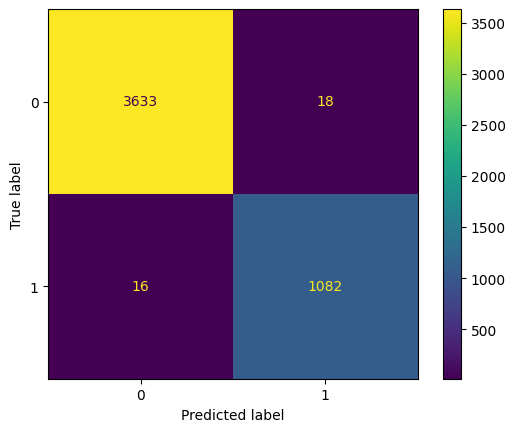

In [45]:
ConfusionMatrixDisplay(conf_matrix).plot()

In [52]:
print(type(best_model))

<class 'keras.src.models.sequential.Sequential'>


In [54]:
# Convert DataFrames to NumPy arrays
x_train_clasi_array = np.array(X_train_clasificacion)
x_test_clasi_array = np.array(X_test_clasificacion)

# Initialize SHAP DeepExplainer
explainer = shap.KernelExplainer(best_model, x_train_clasi_array)

Using 19226 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [55]:
#Corre esto y la pc explota, probar en colab con una gpu
shap_values_clasi = explainer.shap_values(x_test_clasi_array)

  0%|          | 0/4749 [00:00<?, ?it/s]

In [ ]:
# Plot the SHAP values
shap.summary_plot(shap_values_clasi, x_test_clasi_array, feature_names=X_train_clasificacion.columns)

In [48]:
# Obtener la importancia global de las características
shap.summary_plot(
    shap_values_clasi,
    features=x_train_clasi_array,
    feature_names=X_train_clasificacion.columns)

plt.show()

NameError: name 'shap_values_clasi' is not defined

In [ ]:
explainer = shap.Explainer(best_model,
                           X_train_clasificacion.values,
                           feature_names=X_train_clasificacion.columns)

explanation = explainer(X_test_clasificacion)

shap.plots.beeswarm(explanation, max_display=None)